In [1]:
import boost_histogram as bh

In [2]:
import ROOT

Welcome to JupyROOT 6.18/04


In [3]:
import numpy as np

In [21]:
norm_vals = np.concatenate([
    np.random.normal(loc=5, scale=1, size=18_000_000),
    np.random.normal(loc=2, scale=.2, size=1_000_000),
    np.random.normal(loc=8, scale=.2, size=1_000_000),
])

In [22]:
%%timeit
bins, edges = np.histogram(norm_vals, bins=100, range=(0, 10))

146 ms ± 8.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
h1 = ROOT.TH1D("simple", "simple", 100, 0, 10)

In [25]:
%%timeit
h1.Clear()
h1.FillN(len(norm_vals), norm_vals, ROOT.nullptr)

123 ms ± 3.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%%timeit
bins, edges = bh.numpy.histogram(norm_vals, bins=100, range=(0, 10))

65.1 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
h1b = bh.Histogram(bh.axis.Regular(100, 0, 10))

In [33]:
%%timeit
h1b.reset()
h1b.fill(norm_vals)

58.1 ms ± 1.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
%%timeit
h1b.reset()
threaded_fill(h1b, 8, norm_vals)

10.3 ms ± 35.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


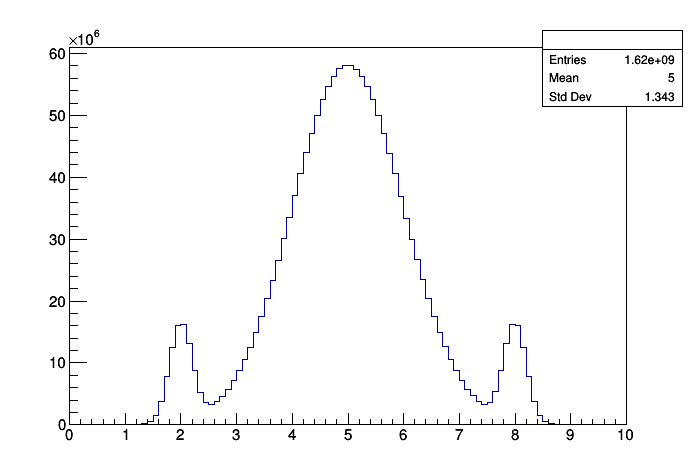

In [26]:
c = ROOT.TCanvas()
h1.Draw()
c.Draw()

In [29]:
data  = np.random.multivariate_normal(
    (0, 0),
    ((1,0),(0,.5)),
    10_000_000).T.copy()

In [30]:
%%timeit
np.histogram2d(*data, bins=(400, 200), range=((-2,2), (-1, 1)))

1.18 s ± 93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
h2 = ROOT.TH2D("simple2", "simple2", 400, -2, 2, 200, -1, 1)

In [36]:
%%timeit
h2.Clear()
h2.FillN(len(data[0]), data[0], data[1], ROOT.nullptr)

157 ms ± 2.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
h2b = bh.Histogram(bh.axis.Regular(400, -2, 2),
                   bh.axis.Regular(200, -1, 1))

In [31]:
%%timeit
bh.numpy.histogram2d(*data, bins=(400, 200), range=((-2,2), (-1, 1)))

93.3 ms ± 3.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
h2b.reset()
h2b.fill(*data)

75.9 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [40]:
from concurrent.futures import ThreadPoolExecutor

def chunks(N, vals):
    "Chunks vals into N chunks, returns chunks"
    frac = len(vals)//N
    for n in range(N):
        yield vals[n*frac:(n+1)*frac]

def threaded_fill(hist, threads, *data):
    def fun(*args):
        return hist.copy().reset().fill(*args)
    
    chunks_list = [chunks(threads, d) for d in data]
    
    with ThreadPoolExecutor(threads) as pool:
        results = pool.map(fun, *chunks_list)
        
    for h in results:
        hist += h

In [43]:
%%timeit
h2b.reset()
threaded_fill(h2b, 8, *data)

14.1 ms ± 129 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
